In [1]:
import os, sys; sys.path.append(os.path.dirname(os.path.realpath('./')))

import numpy as np
from numba import cuda, float32
import utils.utils as u
import random
import math
import time

import cnn.cnn as cnn
import cnn.cnn_sequential as cnn_s
import cnn.cnn_parallel_cpu as cnn_p_cpu
import cnn.cnn_parallel_cuda as cnn_p_gpu

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [3]:
train_data,train_label, test_data, test_label = u.load_data('../mnist/')

Extracting ../mnist/train-images-idx3-ubyte.gz
Extracting ../mnist/train-labels-idx1-ubyte.gz
Extracting ../mnist/t10k-images-idx3-ubyte.gz
Extracting ../mnist/t10k-labels-idx1-ubyte.gz


In [4]:
batch_size = 100

filters=256 #(depth)
kernel_shape=(3, 3, 1)
conv_stride=1
pool_stride=2
pool_size = (2,2)
num_classes = 10

In [5]:

input_dims = (batch_size, train_data.shape[1],train_data.shape[2],train_data.shape[3])
conv_w, conv_b, fully_w, fully_b = cnn.init_network(input_dims,kernel_shape, filters,conv_stride, pool_stride, pool_size,num_classes)
conv_output_shape = (cnn.calculate_convolution_output_dims(input_dims, conv_w.shape,conv_stride))
max_pool_output_shape = (cnn.calculate_maxpool_output_dims(conv_output_shape, pool_stride, pool_size))

In [6]:
X, y = u.next_batch(train_data, train_label, batch_size)

In [7]:
%%time
conv_output = np.zeros(shape=conv_output_shape, dtype=np.float32)
max_pool_output = np.zeros(shape=max_pool_output_shape, dtype=np.float32)
gradients = np.zeros(shape=(batch_size, num_classes), dtype=np.float32)
mlp_output = np.zeros(shape=gradients.shape, dtype=np.float32)
preds = np.zeros(shape=gradients.shape, dtype = np.float32)

g_flatten = np.zeros(shape=(batch_size, max_pool_output_shape[1]*max_pool_output_shape[2]*max_pool_output_shape[3]), dtype=np.float32)
g_max_pool_output = np.zeros(shape=conv_output_shape, dtype=np.float32)

g_fully_w = np.zeros(shape=fully_w.shape, dtype=np.float32)
g_fully_b = np.zeros(shape=fully_b.shape, dtype=np.float32)

g_conv_w = np.zeros(shape=(batch_size,conv_w.shape[0], conv_w.shape[1],conv_w.shape[2],conv_w.shape[3]))
g_conv_b = np.zeros(shape=(batch_size, conv_b.shape[0]), dtype=np.float32)

#train data and labels
Xg = cuda.to_device(X)
yg = cuda.to_device(y)

begin_dt = time.time()
conv_outputg = cuda.to_device(conv_output)
max_pool_outputg = cuda.to_device(max_pool_output)
predsg = cuda.to_device(preds)
gradientsg = cuda.to_device(gradients)
mlp_outputg = cuda.to_device(mlp_output)

g_max_pool_outputg = cuda.to_device(g_max_pool_output)
g_flatten_g = cuda.to_device(g_flatten)

g_fully_wg = cuda.to_device(g_fully_w)
g_fully_bg = cuda.to_device(g_fully_b)
g_conv_wg = cuda.to_device(g_conv_w)
g_conv_bg = cuda.to_device(g_conv_b)

conv_wg = cuda.to_device(conv_w)
conv_bg = cuda.to_device(conv_b)
fully_wg = cuda.to_device(fully_w)
fully_wg_t = cuda.to_device(fully_w.T)
fully_bg = cuda.to_device(fully_b)

duration_to_device = time.time()-begin_dt

#conv & max pooling forwarding
thread_ct = cnn_p_gpu.get_thread_ct(batch_size)
block_ct = (math.ceil(batch_size/thread_ct),1)
cnn_p_gpu.conv_pool_forward[block_ct, thread_ct](Xg,conv_wg,conv_bg,conv_outputg,max_pool_outputg)

#

flatten = max_pool_outputg.copy_to_host()
flatten = flatten.ravel().reshape(batch_size, -1)
flatteng = cuda.to_device(flatten)

thread_ct = (32, 32)
block_ct = list(map(lambda x: int(math.ceil(float(x) / thread_ct[0])), [gradientsg.shape[0], gradientsg.shape[1]]))
cnn_p_gpu.fully_gpu_forward[block_ct, thread_ct](flatteng, fully_wg, fully_bg, mlp_outputg,gradientsg,predsg, yg)

thread_ct = (32, 32)
block_ct = list(map(lambda x: int(math.ceil(float(x) / thread_ct[0])), [flatteng.shape[0], flatteng.shape[1]]))
cnn_p_gpu.fully_gpu_backward[block_ct, thread_ct](flatteng,gradientsg,fully_wg_t,g_fully_wg,g_fully_bg, g_flatten_g)
block_ct = list(map(lambda x: int(math.ceil(float(x) / thread_ct[0])), [fully_w.shape[0], fully_w.shape[1]]))
cnn_p_gpu.fully_gpu_gradients[block_ct, thread_ct](flatteng,gradientsg,fully_wg_t,g_fully_wg,g_fully_bg, g_flatten_g)


g_flatten_g = g_flatten_g.reshape(max_pool_output_shape)
thread_ct = cnn_p_gpu.get_thread_ct(batch_size)
block_ct = list(map(lambda x: int(math.ceil(float(x) / thread_ct)), [batch_size, 1]))
cnn_p_gpu.conv_pool_backward[block_ct, thread_ct](Xg, conv_outputg, g_flatten_g, g_max_pool_outputg, g_conv_wg,g_conv_bg)


X = Xg.copy_to_host()
y = yg.copy_to_host()

conv_output = conv_outputg.copy_to_host()
max_pool_output = max_pool_outputg.copy_to_host()
flatten = flatteng.copy_to_host()
gradients = gradientsg.copy_to_host()
preds = predsg.copy_to_host()

g_max_pool_output = g_max_pool_outputg.copy_to_host()

conv_w = conv_wg.copy_to_host()
conv_b = conv_bg.copy_to_host()

fully_w = fully_wg.copy_to_host()
fully_b = fully_bg.copy_to_host()
fully_w_t = fully_wg_t.copy_to_host()
g_fully_w = g_fully_wg.copy_to_host()
g_fully_b = g_fully_bg.copy_to_host()
g_conv_w = g_conv_wg.copy_to_host()
g_conv_b = g_conv_bg.copy_to_host()
g_flatten = g_flatten_g.copy_to_host()


g_conv_w = np.sum(g_conv_w, axis=0)
g_conv_b = np.sum(g_conv_b, axis=0)/100


Wall time: 3.37 s


In [8]:
%%time
preds3, cv_g_weights3, cv_g_biases3 , fully_g_weigths, fully_g_biases \
= cnn_s.train_one_epoch(X, y,conv_stride, pool_stride, conv_w, conv_b, fully_w, fully_b,pool_size)

Wall time: 2.55 s


In [9]:
i = random.randint(0,fully_g_weigths.shape[0]-1)
fully_g_weigths[i], g_fully_w[i]

(array([ 1.6328154e-06,  1.1575987e-06,  9.3043695e-04,  3.4151387e-06,
         3.3658939e-08,  4.8716523e-05,  8.5657723e-07, -9.9527289e-04,
         6.0881198e-06,  2.9355222e-06], dtype=float32),
 array([ 1.6328154e-06,  1.1575989e-06,  9.3043689e-04,  3.4151390e-06,
         3.3658953e-08,  4.8716523e-05,  8.5657723e-07, -9.9527289e-04,
         6.0881193e-06,  2.9355224e-06], dtype=float32))

In [10]:
g_conv_b[:19],cv_g_biases3[:19]

(array([ 0.40487653,  0.4708403 ,  0.49565065,  0.9162395 ,  0.03946549,
        -0.3551053 , -0.12524453,  0.83795094, -0.6632446 , -0.38729584,
        -0.14068127, -0.5997239 ,  0.80490476, -0.11941944,  0.25386384,
         0.5557243 ,  0.15162201, -0.33094668, -0.6795557 ], dtype=float32),
 array([ 0.40487648,  0.47084021,  0.4956507 ,  0.91623946,  0.03946545,
        -0.3551052 , -0.12524446,  0.83795111, -0.66324469, -0.38729581,
        -0.14068118, -0.59972376,  0.80490478, -0.11941941,  0.25386387,
         0.55572437,  0.15162206, -0.33094664, -0.6795557 ]))

57


(None,)

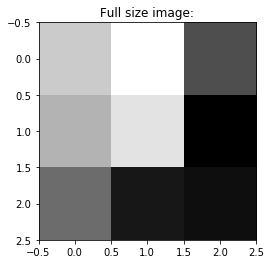

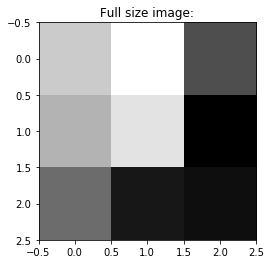

In [11]:
filter = random.randint(0,filters-1)
print(filter)
u.plot_image(cv_g_weights3[:,:,0,filter]),
u.plot_image(g_conv_w[:,:,0,filter]),